In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pylab as plt

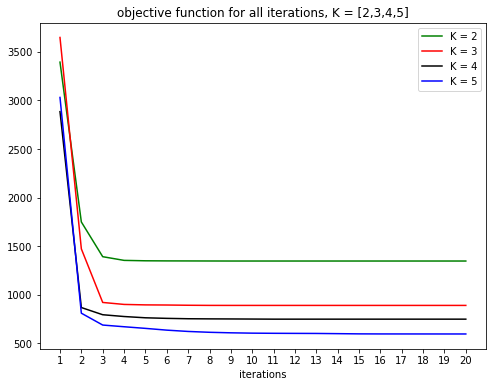

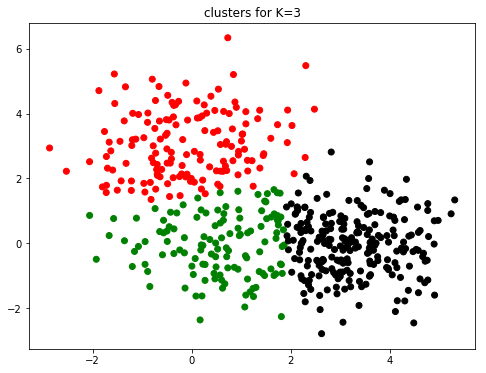

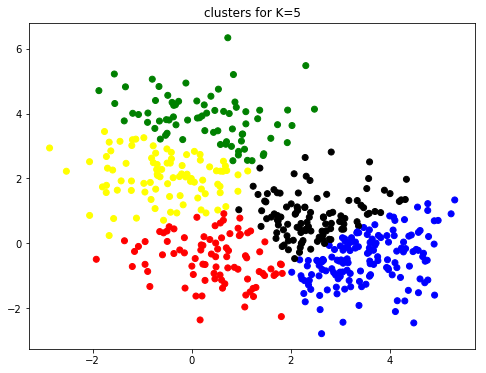

In [9]:
def kmeans_gaussian(k,T,data):
    
    
    center_points = np.random.uniform(low=0,high=1,size=(k,2))
    objective = []
    
    def get_closest_cluster(row):
        errors = np.sum((center_points - row)**2,axis=1)
        sel = np.argmin(errors)
        return (sel,errors[sel])


    for t in range(T):
        cluster_groups = np.apply_along_axis(get_closest_cluster,1,data)
        
        objective.append(np.sum(cluster_groups[:,1]))

        for i in range(k):
            center_points[i,:] = np.mean(data[cluster_groups[:,0]==i],axis=0)
    
    return objective,cluster_groups



def kmeans_function():

    T=20
    ntrain = 500
    weights = [0.2,0.5,0.3]
    
    cov = np.matrix([[1,0],[0,1]])
    mean_1 = np.array([0,0])
    mean_2 = np.array([3,0])
    mean_3 = np.array([0,3])
    gaussian_1 = np.random.multivariate_normal(mean_1,cov,ntrain)
    gaussian_2 = np.random.multivariate_normal(mean_2,cov,ntrain)
    gaussian_3 = np.random.multivariate_normal(mean_3,cov,ntrain)
    choice = np.random.choice(range(3),size=500,p=weights)
    data = np.concatenate(( gaussian_1[choice==0,:],gaussian_2[choice==1,:],gaussian_3[choice==2,:] ))


    k_range = range(2,6)
    colors = ['green','red','black','blue','yellow']

    k_ans = [3,5]
    cluster_3_5 = []

    plt.figure(figsize=(8,6))
    for i in range(len(k_range)):
        
        km_objective,km_cluster_assgn = kmeans_gaussian(k_range[i],T,data)
        plt.plot(range(1,T+1),km_objective,colors[i])

        if k_range[i] in k_ans:
            cluster_3_5.append(km_cluster_assgn[:,0])

    plt.xticks(range(1,T+1))
    plt.xlabel('iterations')
    plt.title('objective function for all iterations, K = [2,3,4,5]')
    plt.legend(['K = %d'%i for i in k_range])

    for i in range(2):
        plt.figure(figsize=(8,6))
        colors_arr = [colors[int(x)] for x in cluster_3_5[i]]
        plt.scatter(data[:,0],data[:,1],c=colors_arr)
        plt.title('clusters for K=%d'%k_ans[i])
        plt.show()


kmeans_function()

In [2]:

def calculate_error(matrix,A,B):

    predicted=A.dot(B)
    observed=~np.isnan(matrix)

    error=((matrix[observed] - predicted[observed])**2).sum()
    return error

def calculate_sum(matrix):
    return (matrix**2).sum()


def matrix_factorization(train, test, movie_mapping):
    
    nusers=943
    nmovies=1682
    var=0.25
    d=10 
    lmb=1
    num_train_cases = 0
    num_test_cases = 0

    
    matrix = np.repeat(np.nan,nusers*nmovies).reshape(nusers,nmovies)

    with open(train) as f:
        for row in f:
            val = row.rstrip('\n').split(',')
            matrix[int(val[0])-1, int(val[1])-1] = float(val[2])
            num_train_cases+=1
            
    M = matrix
    
    matrix = np.repeat(np.nan,nusers*nmovies).reshape(nusers,nmovies)
    with open(test) as f:
        for row in f:
            val = row.rstrip('\n').split(',')
            matrix[int(val[0])-1, int(val[1])-1] = float(val[2])
            num_test_cases+=1

    M_test = matrix                
    with open(movie_mapping) as f:
        movies = np.array([x.rstrip('\n') for x in f.readlines()])

    num_runs = 10
    x_vals = list(range(2,100))
    results = pd.DataFrame(index=range(num_runs),columns=['s.no.','objective','test_rmse'])
    query_movies = ["Star Wars", "My Fair Lady", "GoodFellas"]
    movie_results = pd.DataFrame(index=range(10),columns=query_movies)
    dist_results = pd.DataFrame(index=range(10),columns=query_movies)

    max_obj = -np.inf
    results['s.no.'] = list(range(1,num_runs+1))

    plt.figure()
    for rit in range(num_runs):
        
        B = np.random.multivariate_normal(np.repeat(0,d),np.identity(d)/lmb,nmovies).T
        A = np.repeat(np.nan,nusers*d).reshape(nusers,d)
                
        objective = []
        for p in range(100):
            for i in range(nusers):
                observed = ~np.isnan(M[i,:])
                Ri = B[:,observed]
                Mi = M[i,observed]
                A[i,:] = np.linalg.inv( Ri.dot(Ri.T)+lmb*var*np.identity(d)).dot(Ri.dot(Mi.T))

            for j in range(nmovies):
                observed = ~np.isnan(M[:,j])
                Qj = A[observed,:]
                Mj = M[observed,j]
                B[:,j] = np.linalg.inv(Qj.T.dot(Qj)+lmb*var*np.identity(d)).dot(Qj.T.dot(Mj.T))

            if p>1:
                obj_neg = (calculate_error(M,A,B)/(2*var)+calculate_sum(A)*lmb/2 + calculate_sum(B)*lmb/2)
                objective.append(-obj_neg)

        plt.plot(x_vals, objective, label='Code run %d'%(rit+1))
        results.loc[rit,'objective'] = objective[-1]
        results.loc[rit,'test_rmse'] = np.sqrt(calculate_error(M_test,A,B)/num_test_cases)

        if objective[-1]>max_obj:
            max_obj = objective[-1]
            
            for movie in query_movies:
                movie_id = [var for var in range(nmovies) if movie in movies[var]][0]
                distances = np.sqrt(((B - B[:,movie_id].reshape(-1,1))**2).sum(axis=0))
                min_movies_id = np.argsort(distances)[1:11]
                movie_results[movie] = movies[min_movies_id]
                dist_results[movie] = distances[min_movies_id]
    

    plt.xticks([int(x) for x in np.linspace(2,100,10)])
    plt.xlabel('Iteration')
    plt.title('10 Iterations of code')
    plt.legend(loc='best')
    plt.show()

    results=results.sort_values(by='objective',axis=0,ascending=False)
    results.to_csv('hw4_2a.csv',index=False)
    print(results)
    print(movie_results)
    print(dist_results)
    movie_results.to_csv('hw4_2b.csv',index=False)
    dist_results.to_csv('hw4_2c.csv',index=False)



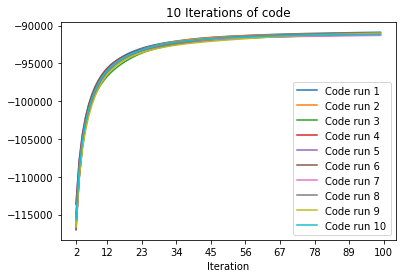

   s.no. objective test_rmse
0      1  -90889.1   1.11369
7      8  -90959.5   1.11308
3      4  -91005.7   1.14378
1      2  -91012.3   1.10998
8      9  -91023.1   1.11568
9     10  -91170.4   1.10659
5      6  -91177.3   1.09959
4      5  -91179.7   1.16125
2      3  -91200.4   1.10709
6      7  -91307.9   1.09041
                                   Star Wars  \
0            Empire Strikes Back, The (1980)   
1             Raiders of the Lost Ark (1981)   
2                  Return of the Jedi (1983)   
3                 Usual Suspects, The (1995)   
4                 Wrong Trousers, The (1993)   
5  Indiana Jones and the Last Crusade (1989)   
6                   Great Escape, The (1963)   
7                     Terminator, The (1984)   
8                          Sting, The (1973)   
9                       Meet John Doe (1941)   

                             My Fair Lady  \
0                     Mary Poppins (1964)   
1            American in Paris, An (1951)   
2  Snow White and

In [3]:
train = "ratings.csv"
test = "ratings_test.csv"
mmap = "movies.txt"
matrix_factorization(train, test, mmap)



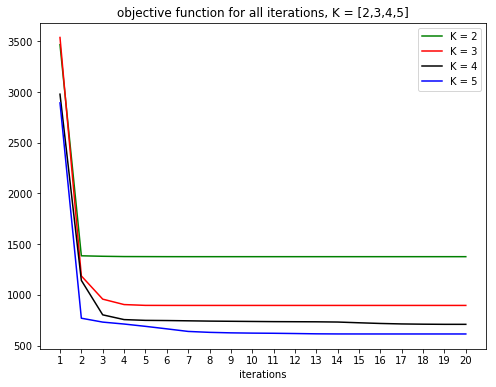

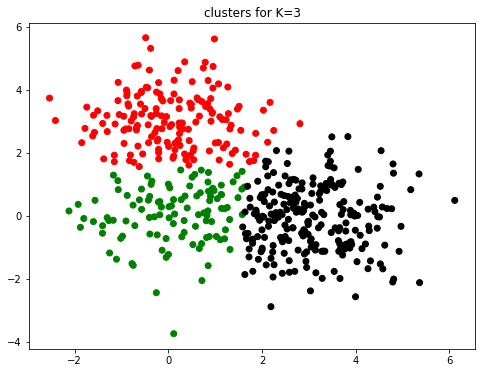

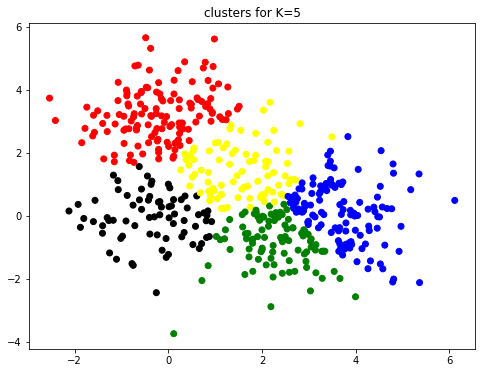

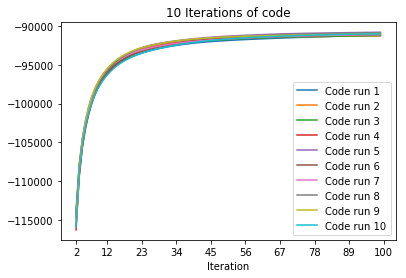

   s.no. objective test_rmse
4      5    -90809    1.1331
7      8  -90869.7    1.0981
3      4  -90911.8   1.09641
8      9  -90976.6   1.14659
9     10  -91009.4   1.13414
5      6  -91107.8   1.14454
6      7  -91123.3    1.1261
0      1    -91186   1.12581
2      3  -91236.5   1.11774
1      2    -91277   1.12883
                                   Star Wars  \
0            Empire Strikes Back, The (1980)   
1             Raiders of the Lost Ark (1981)   
2                  Return of the Jedi (1983)   
3                 Blues Brothers, The (1980)   
4      Day the Earth Stood Still, The (1951)   
5                     Terminator, The (1984)   
6  Indiana Jones and the Last Crusade (1989)   
7                 Usual Suspects, The (1995)   
8          Terminator 2: Judgment Day (1991)   
9        Star Trek: The Wrath of Khan (1982)   

                             My Fair Lady  \
0                     Mary Poppins (1964)   
1            Sense and Sensibility (1995)   
2              So

In [1]:

# coding: utf-8

# In[1]:

import numpy as np
import pandas as pd
import csv
import matplotlib.pylab as plt


# In[9]:

def kmeans_gaussian(k,T,data):
    
    
    center_points = np.random.uniform(low=0,high=1,size=(k,2))
    objective = []
    
    def get_closest_cluster(row):
        errors = np.sum((center_points - row)**2,axis=1)
        sel = np.argmin(errors)
        return (sel,errors[sel])


    for t in range(T):
        cluster_groups = np.apply_along_axis(get_closest_cluster,1,data)
        
        objective.append(np.sum(cluster_groups[:,1]))

        for i in range(k):
            center_points[i,:] = np.mean(data[cluster_groups[:,0]==i],axis=0)
    
    return objective,cluster_groups



def kmeans_function():

    T=20
    ntrain = 500
    weights = [0.2,0.5,0.3]
    
    cov = np.matrix([[1,0],[0,1]])
    mean_1 = np.array([0,0])
    mean_2 = np.array([3,0])
    mean_3 = np.array([0,3])
    gaussian_1 = np.random.multivariate_normal(mean_1,cov,ntrain)
    gaussian_2 = np.random.multivariate_normal(mean_2,cov,ntrain)
    gaussian_3 = np.random.multivariate_normal(mean_3,cov,ntrain)
    choice = np.random.choice(range(3),size=500,p=weights)
    data = np.concatenate(( gaussian_1[choice==0,:],gaussian_2[choice==1,:],gaussian_3[choice==2,:] ))


    k_range = range(2,6)
    colors = ['green','red','black','blue','yellow']

    k_ans = [3,5]
    cluster_3_5 = []

    plt.figure(figsize=(8,6))
    for i in range(len(k_range)):
        
        km_objective,km_cluster_assgn = kmeans_gaussian(k_range[i],T,data)
        plt.plot(range(1,T+1),km_objective,colors[i])

        if k_range[i] in k_ans:
            cluster_3_5.append(km_cluster_assgn[:,0])

    plt.xticks(range(1,T+1))
    plt.xlabel('iterations')
    plt.title('objective function for all iterations, K = [2,3,4,5]')
    plt.legend(['K = %d'%i for i in k_range])

    for i in range(2):
        plt.figure(figsize=(8,6))
        colors_arr = [colors[int(x)] for x in cluster_3_5[i]]
        plt.scatter(data[:,0],data[:,1],c=colors_arr)
        plt.title('clusters for K=%d'%k_ans[i])
        plt.show()


kmeans_function()


# In[ ]:




# In[2]:


def calculate_error(matrix,A,B):

    predicted=A.dot(B)
    observed=~np.isnan(matrix)

    error=((matrix[observed] - predicted[observed])**2).sum()
    return error

def calculate_sum(matrix):
    return (matrix**2).sum()


def matrix_factorization(train, test, movie_mapping):
    
    nusers=943
    nmovies=1682
    var=0.25
    d=10 
    lmb=1
    num_train_cases = 0
    num_test_cases = 0

    
    matrix = np.repeat(np.nan,nusers*nmovies).reshape(nusers,nmovies)

    with open(train) as f:
        for row in f:
            val = row.rstrip('\n').split(',')
            matrix[int(val[0])-1, int(val[1])-1] = float(val[2])
            num_train_cases+=1
            
    M = matrix
    
    matrix = np.repeat(np.nan,nusers*nmovies).reshape(nusers,nmovies)
    with open(test) as f:
        for row in f:
            val = row.rstrip('\n').split(',')
            matrix[int(val[0])-1, int(val[1])-1] = float(val[2])
            num_test_cases+=1

    M_test = matrix                
    with open(movie_mapping) as f:
        movies = np.array([x.rstrip('\n') for x in f.readlines()])

    num_runs = 10
    x_vals = list(range(2,100))
    results = pd.DataFrame(index=range(num_runs),columns=['s.no.','objective','test_rmse'])
    query_movies = ["Star Wars", "My Fair Lady", "GoodFellas"]
    movie_results = pd.DataFrame(index=range(10),columns=query_movies)
    dist_results = pd.DataFrame(index=range(10),columns=query_movies)

    max_obj = -np.inf
    results['s.no.'] = list(range(1,num_runs+1))

    plt.figure()
    for rit in range(num_runs):
        
        B = np.random.multivariate_normal(np.repeat(0,d),np.identity(d)/lmb,nmovies).T
        A = np.repeat(np.nan,nusers*d).reshape(nusers,d)
                
        objective = []
        for p in range(100):
            for i in range(nusers):
                observed = ~np.isnan(M[i,:])
                Ri = B[:,observed]
                Mi = M[i,observed]
                A[i,:] = np.linalg.inv( Ri.dot(Ri.T)+lmb*var*np.identity(d)).dot(Ri.dot(Mi.T))

            for j in range(nmovies):
                observed = ~np.isnan(M[:,j])
                Qj = A[observed,:]
                Mj = M[observed,j]
                B[:,j] = np.linalg.inv(Qj.T.dot(Qj)+lmb*var*np.identity(d)).dot(Qj.T.dot(Mj.T))

            if p>1:
                obj_neg = (calculate_error(M,A,B)/(2*var)+calculate_sum(A)*lmb/2 + calculate_sum(B)*lmb/2)
                objective.append(-obj_neg)

        plt.plot(x_vals, objective, label='Code run %d'%(rit+1))
        results.loc[rit,'objective'] = objective[-1]
        results.loc[rit,'test_rmse'] = np.sqrt(calculate_error(M_test,A,B)/num_test_cases)

        if objective[-1]>max_obj:
            max_obj = objective[-1]
            
            for movie in query_movies:
                movie_id = [var for var in range(nmovies) if movie in movies[var]][0]
                distances = np.sqrt(((B - B[:,movie_id].reshape(-1,1))**2).sum(axis=0))
                min_movies_id = np.argsort(distances)[1:11]
                movie_results[movie] = movies[min_movies_id]
                dist_results[movie] = distances[min_movies_id]
    

    plt.xticks([int(x) for x in np.linspace(2,100,10)])
    plt.xlabel('Iteration')
    plt.title('10 Iterations of code')
    plt.legend(loc='best')
    plt.show()

    results=results.sort_values(by='objective',axis=0,ascending=False)
    results.to_csv('hw4_2a.csv',index=False)
    print(results)
    print(movie_results)
    print(dist_results)
    movie_results.to_csv('hw4_2b.csv',index=False)
    dist_results.to_csv('hw4_2c.csv',index=False)



# In[3]:

train = "ratings.csv"
test = "ratings_test.csv"
mmap = "movies.txt"
matrix_factorization(train, test, mmap)



# In[ ]:



